In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_normal(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        #预测模式（评估模式）直接使用传入的(训练好的)移动平均所得的均值和方差moving_
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
       # X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        #训练模式下，需要调整移动平均所得的均值和误差
        assert len(X.shape) in (2,4)     #全连接层输入是二维的，卷积层输入是4维的
        if len(X.shape)==2:
           #计算本批次的均值。方差以便后面指数加权使用
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            mean=X.mean(dim=(0,2,3),keepdim=True)   #保持维度以便后面求方差用(自动广播)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        #训练模式下不断更新指数加权平均值和方差，最后得到整个训练集的加权均值和方差，以便后面测试的时候使用
        #训练的时候由于得不到整个训练集的指数加权均值和方差，所以使用批量的均值训练
        #测试的时候使用训练集的均值而不是用测试集的均值是因为要保证训练和测试的参数一致
        X_hat=(X-mean)/torch.sqrt(var+eps)
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta
    return Y,moving_mean.data,moving_var.data

In [2]:
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        #num_dims判断输入类型是图片(4)还是数据类型(2)
        #num_features判断输入的特征个数（图片为通道数）
        super(BatchNorm,self).__init__()
        assert num_dims in (2,4)
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        #需要训练的参数
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        #不需要训练的非模型参数
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
    
    def forward(self,X):
        #判断X是不是在内存（存储在cpu上）上，如果在显存（存储在GPU上）上，则将moving_mean,moving_var移动到显存上去
        #gamma和beta不用在这里移动是因为他是parameters参数，调用net.to(device)的时候会移动过去
        if X.device!=self.moving_mean.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        #保存更新过的moving_mean、moving_var
        Y,self.moving_mean,self.moving_var=batch_normal(X,self.gamma,self.beta,
                                                        self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
        return Y

In [3]:
#Lenet
net=nn.Sequential(nn.Conv2d(1,6,kernel_size=5,stride=1),BatchNorm(6,num_dims=4),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Flatten(),
                  nn.Linear(256,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
                  nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
                  nn.Linear(84,10))


loss 0.269, train acc 0.900, test acc 0.811
32931.7 examples/sec on cuda:0


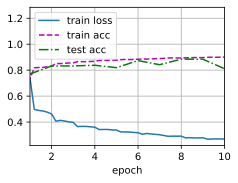

In [4]:
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr=lr,device=d2l.try_gpu())

In [9]:
net=nn.Sequential(nn.Conv2d(1,6,kernel_size=5,stride=1),nn.BatchNorm2d(6),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Conv2d(6,16,kernel_size=5,stride=1),nn.BatchNorm2d(16),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Flatten(),
                  nn.Linear(256,120),nn.BatchNorm1d(120),nn.Sigmoid(),
                  nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
                  nn.Linear(84,10))

loss 0.271, train acc 0.900, test acc 0.883
51770.9 examples/sec on cuda:0


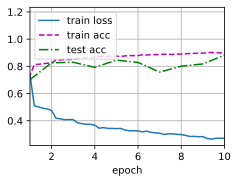

In [10]:
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,device=d2l.try_gpu())